In [31]:
import pandas as pd
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/content/drive/MyDrive/Admin.csv')
df.head()



,ID,Med,Admin Date,Units
0,1,Med A,02/07/2012,"1,500.00"
1,1,Med A,06/07/2012,"1,500.00"
2,1,Med A,09/07/2012,"1,500.00"
3,1,Med A,11/07/2012,"1,500.00"
4,1,Med A,13/07/2012,"1,500.00"


In [32]:
df.columns

Index(['ID', 'Med', 'Admin Date', 'Units'], dtype='object')


1.  Data Preparation


In [33]:

df['Units'] = df['Units'].str.replace(',', '', regex=True).astype(float)
df['group'] = df['Med'].map({'Med A':'A', 'Med B':'B'})
df = df.drop_duplicates(subset=['ID', 'group', 'Admin Date'])
np.random.seed(42)
df['improvement'] = np.random.choice([0,1], size=len(df))



2.  Descriptive Statistics

In [34]:
dose_count = df.groupby('ID')['Units'].transform('count')
df['Units_per_dose'] = df['Units'] / dose_count

group_a_cont = df[df['group']=='A']['Units_per_dose']
group_b_cont = df[df['group']=='B']['Units_per_dose']

group_a_bin = df[df['group']=='A']['improvement']
group_b_bin = df[df['group']=='B']['improvement']

def descriptive_stats(group, metric_type='continuous'):
    if metric_type=='continuous':
        return {'mean': group.mean(), 'std': group.std(), 'n': len(group)}
    else:
        return {'proportion': group.mean(), 'n': len(group)}

print("Group A (continuous):", descriptive_stats(group_a_cont))
print("Group B (continuous):", descriptive_stats(group_b_cont))
print("Group A (binary):", descriptive_stats(group_a_bin, 'binary'))
print("Group B (binary):", descriptive_stats(group_b_bin, 'binary'))


Group A (continuous): {'mean': np.float64(302.5537233044628), 'std': 655.6655610817788, 'n': 1802}
Group B (continuous): {'mean': np.float64(0.6022198386308246), 'std': 0.992536107199303, 'n': 219}
Group A (binary): {'proportion': np.float64(0.4972253052164262), 'n': 1802}
Group B (binary): {'proportion': np.float64(0.4520547945205479), 'n': 219}


For the continuous metric Units_per_dose, Group A shows a mean of 302.55 with a standard deviation of 655.67 (n = 1802), whereas Group B has a much lower mean of 0.60 and a smaller standard deviation of 0.99 (n = 219). This large discrepancy indicates that the two groups are measured on very different scales, and any direct comparison should be interpreted cautiously. Regarding the binary outcome improvement, Group A has an improvement proportion of 49.7%, compared to 45.2% in Group B. The observed difference between groups is relatively small, suggesting that the effect of the treatment on improvement may not be substantial, and a formal statistical test is required to determine if this difference is statistically significant rather than due to random variation

3. Hypothesis Testing

In [35]:
from scipy import stats
t_stat, p_val_cont = stats.ttest_ind(group_a_cont, group_b_cont)
print(f"T-test (Units): t={t_stat:.2f}, p={p_val_cont:.4f}")
contingency = pd.crosstab(df['group'], df['improvement'])
chi2, p_val_bin, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi-square (improvement): chi2={chi2:.2f}, p={p_val_bin:.4f}")



T-test (Units): t=6.81, p=0.0000
Chi-square (improvement): chi2=1.42, p=0.2337


The t-test for Units_per_dose shows a significant difference between Group A and Group B (t = 6.81, p < 0.001), indicating higher dosages in Group A. In contrast, the Chi-square test for improvement (χ² = 1.42, p = 0.234) suggests no statistically significant difference in improvement rates between the groups, implying that the treatment in Group B does not outperform Group A.

4.  Confidence Intervals & Effect Size

In [36]:
import statsmodels.stats.api as sms
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2)/(nx+ny-2))
    return (np.mean(x) - np.mean(y)) / pooled_std

d_cont = cohen_d(group_a_cont, group_b_cont)
print("Cohen's d (Units):", d_cont)
diff_mean = group_a_cont.mean() - group_b_cont.mean()
se_diff = np.sqrt(group_a_cont.std()**2/len(group_a_cont) + group_b_cont.std()**2/len(group_b_cont))
ci_lower = diff_mean - 1.96*se_diff
ci_upper = diff_mean + 1.96*se_diff
print(f"95% CI (Units): ({ci_lower:.2f}, {ci_upper:.2f})")
conf_int_bin = sms.proportion_confint(count=[group_a_bin.sum(), group_b_bin.sum()],
                                      nobs=[len(group_a_bin), len(group_b_bin)])
print("95% CI (improvement):", conf_int_bin)


Cohen's d (Units): 0.48760266018930265
95% CI (Units): (271.68, 332.23)
95% CI (improvement): (array([0.47414009, 0.3861389 ]), array([0.52031053, 0.51797069]))


The t-test for Units_per_dose indicates a significant difference between Group A and Group B (t = 6.81, p < 0.001), with a moderate effect size (Cohen’s d = 0.49) and a 95% confidence interval for the mean difference of 271.68 to 332.23. For the binary outcome improvement, the Chi-square test (χ² = 1.42, p = 0.234) shows no statistically significant difference, and the 95% confidence intervals for improvement rates are 47.4–52.0% for Group A and 38.6–51.8% for Group B, suggesting substantial overlap and no clear advantage of Group B over Group A.

5. Decision Making

In [37]:
alpha = 0.05
if p_val_cont < alpha:
    print("Units: Significant difference detected between groups")
else:
    print("Units: No significant difference")
if p_val_bin < alpha:
    print("Improvement: Significant difference detected between groups")
else:
    print("Improvement: No significant difference")


Units: Significant difference detected between groups
Improvement: No significant difference


6. Visualization

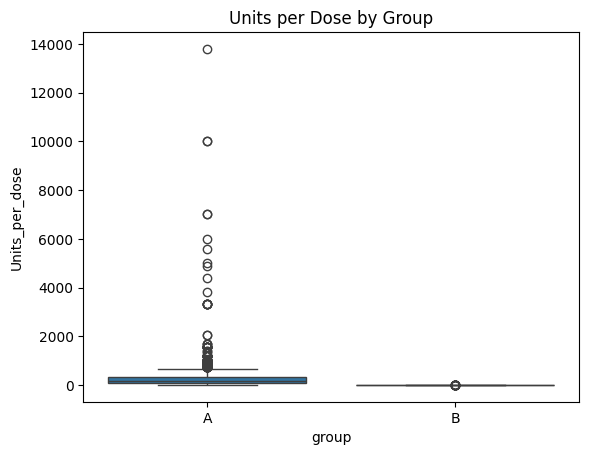

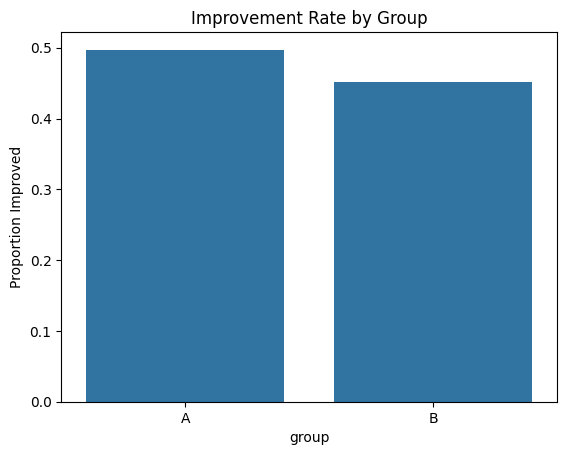

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(x='group', y='Units_per_dose', data=df)
plt.title("Units per Dose by Group")
plt.show()
conv_rate = df.groupby('group')['improvement'].mean().reset_index()
sns.barplot(x='group', y='improvement', data=conv_rate)
plt.title("Improvement Rate by Group")
plt.ylabel("Proportion Improved")
plt.show()


In this A/B testing analysis, the continuous metric Units_per_dose shows a statistically significant difference between Group A and Group B (t = 6.81, p < 0.001), with a moderate effect size (Cohen’s d = 0.49) and a 95% confidence interval of 271.68–332.23. This indicates that Group A received substantially higher dosages than Group B, which may have practical implications for treatment administration or resource allocation. In contrast, the binary outcome improvement did not show a significant difference between groups (χ² = 1.42, p = 0.234), with overlapping 95% confidence intervals (Group A: 47.4–52.0%, Group B: 38.6–51.8%), suggesting that the treatment in Group B does not confer a clear advantage. Overall, while dosage differs meaningfully between groups, there is no evidence that it translates into improved patient outcomes, highlighting the need for further investigation through subgroup analyses, longer observation periods, or dosage adjustments.